In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import imageio
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from numpy.random import randn
from numpy.random import randint
import tensorflow as tf

In [76]:
# using only 10000 images from the dataset
train_dir = '../input/celebs/celeba' 
n_images = 10000
batch_size = 64
latent_dim = 100
n_epoch = 120
img_shape = (64, 64, 3)
images = os.listdir(train_dir)
images = images[:n_images]

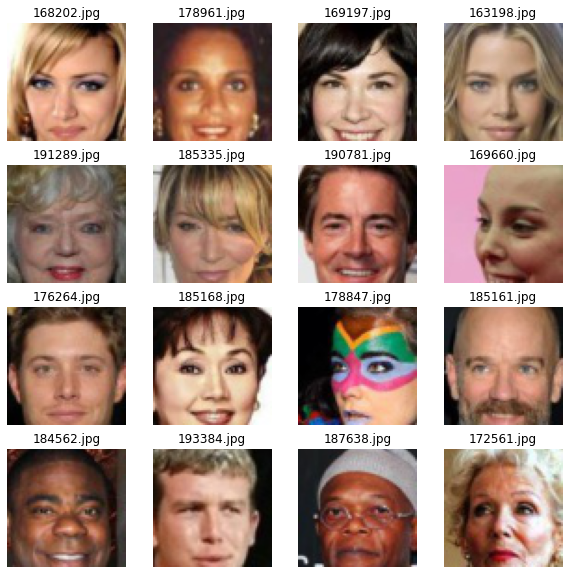

In [77]:
plt.figure(figsize=(10,10))
for i, name in enumerate(images[:16]):
    plt.subplot(4, 4, i + 1)
    img = plt.imread(train_dir + '/' + name)
    plt.imshow(img)
    plt.title(name)
    plt.axis('off')

In [78]:
def get_data(data_path) :
    X = []
    for filename in data_path :
        img = img_to_array(load_img(train_dir + "/" + filename, target_size = img_shape[:2]))
        X.append(img)
    X = np.array(X).astype('float32')
    X = X / 255
    return X

dataset = get_data(images)

In [79]:
# Generator
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 64 * 8 * 8
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 64)))
    # upsample to 16x16
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # output layer 64x64x3
    model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
    model.summary()
    return model

In [80]:
#input of G
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


In [81]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

In [82]:
def show_generated(generated,epoch, n=2):
    plt.figure(figsize=(10,10))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.imshow(generated[i]))
        plt.axis('off')
    plt.savefig('image_{:04d}.png'.format(epoch+1))
    plt.show()    

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 16, 16, 64)        65600     
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 32, 32, 64)        65600     
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 32, 32, 64)      

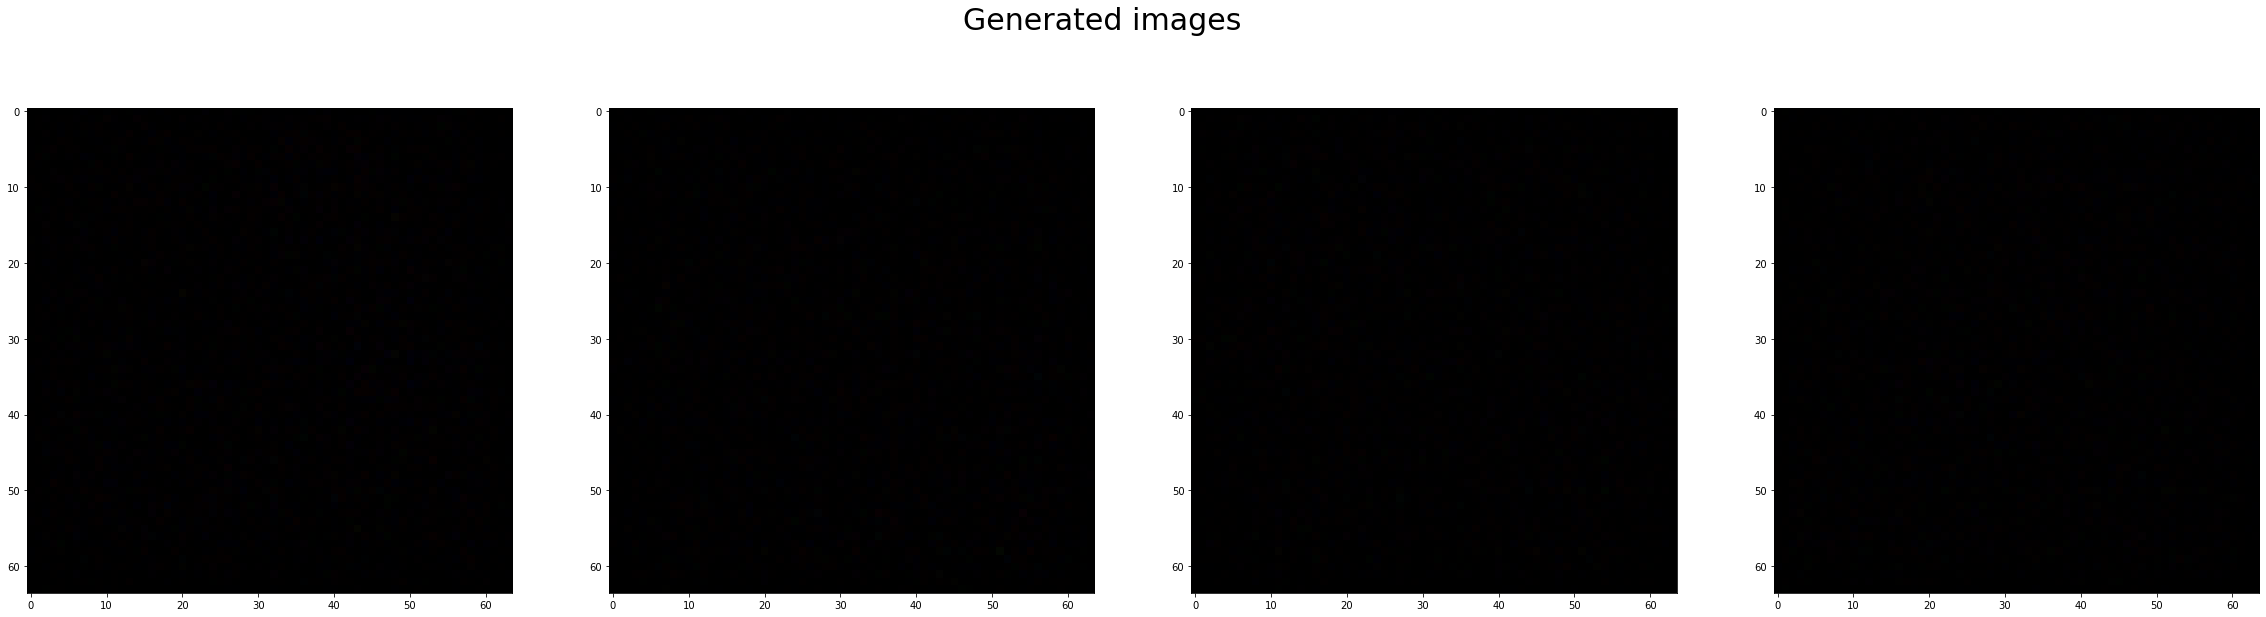

In [83]:
# generatied images BEFORE any training.Our generator knows nothing about it and it outputs some random noise 
def plot_generated_images(imgs):
    fig = plt.figure(figsize=(40,10))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(1,4,i+1)
        ax.imshow(img)
    fig.suptitle("Generated images ",fontsize=30)
    
    plt.show()
generator = define_generator(latent_dim)
x_fake, y_fake = generate_fake_samples(generator, latent_dim, 4)
plot_generated_images(x_fake)

In [84]:
# Discriminator
def define_discriminator(in_shape=(64,64,3)):
    model = Sequential()
    model.add(Conv2D(64, (5,5), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 32x32
    model.add(Conv2D(64, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 16x16
    model.add(Conv2D(64, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 8x8
    model.add(Conv2D(64, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    return model

In [85]:
# Combine generator and discriminator to form gan
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


In [86]:
# retreive real samples
def get_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # set 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

In [87]:
# evaluate the discriminator and plot generated images
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = get_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy [real: %.0f%%, fake: %.0f%%]' % (acc_real*100, acc_fake*100))
    # show plot
    show_generated(x_fake, epoch)

In [88]:
#Train
def train(g_model, d_model, gan_model, dataset, latent_dim=100, n_epochs=120, n_batch=64):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    start = time.time()
    for i in range(n_epochs):
        
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = get_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
        print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (i+1, d_loss1, d_loss2, g_loss))
        # evaluate the model performance
        if (i+1) % 5 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)     
    print ('Total time for training {} epochs is {} sec'.format(n_epochs, (time.time()-start)))

In [89]:
# create the gan
discriminator = define_discriminator()
gan = define_gan(generator, discriminator)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 64, 64, 64)        4864      
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 64)        102464    
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 64)        102464    
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 8, 8, 64)        

Epoch: 1,  Loss: D_real = 0.534, D_fake = 0.639,  G = 0.958
Epoch: 2,  Loss: D_real = 0.498, D_fake = 0.594,  G = 1.148
Epoch: 3,  Loss: D_real = 0.529, D_fake = 0.549,  G = 0.990
Epoch: 4,  Loss: D_real = 0.600, D_fake = 0.671,  G = 0.921
Epoch: 5,  Loss: D_real = 0.581, D_fake = 0.619,  G = 0.908
>Accuracy [real: 79%, fake: 70%]


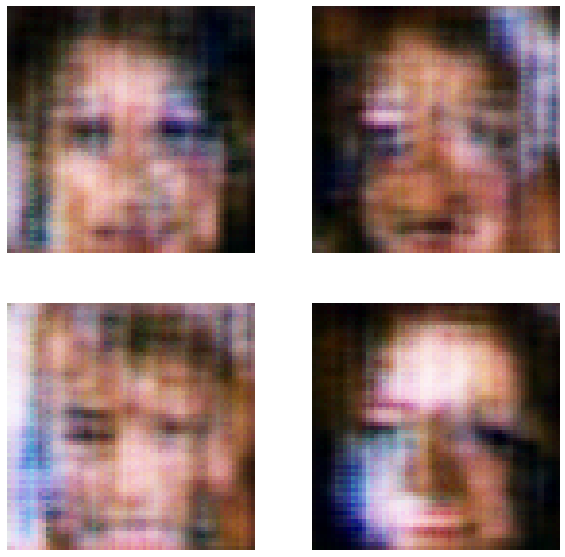

Epoch: 6,  Loss: D_real = 0.641, D_fake = 0.661,  G = 0.792
Epoch: 7,  Loss: D_real = 0.645, D_fake = 0.669,  G = 0.836
Epoch: 8,  Loss: D_real = 0.587, D_fake = 0.725,  G = 1.004
Epoch: 9,  Loss: D_real = 0.621, D_fake = 0.578,  G = 0.902
Epoch: 10,  Loss: D_real = 0.667, D_fake = 0.576,  G = 1.023
>Accuracy [real: 61%, fake: 88%]


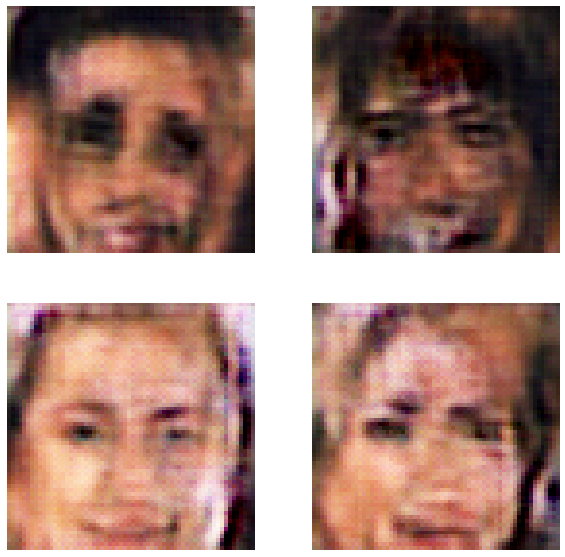

Epoch: 11,  Loss: D_real = 0.659, D_fake = 0.643,  G = 1.020
Epoch: 12,  Loss: D_real = 0.579, D_fake = 0.624,  G = 0.935
Epoch: 13,  Loss: D_real = 0.467, D_fake = 0.615,  G = 0.933
Epoch: 14,  Loss: D_real = 0.743, D_fake = 0.535,  G = 0.907
Epoch: 15,  Loss: D_real = 0.599, D_fake = 0.686,  G = 0.837
>Accuracy [real: 49%, fake: 68%]


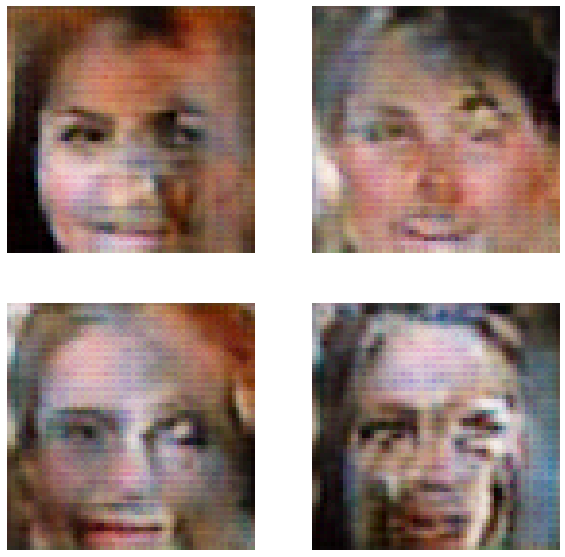

Epoch: 16,  Loss: D_real = 0.695, D_fake = 0.666,  G = 0.856
Epoch: 17,  Loss: D_real = 0.662, D_fake = 0.696,  G = 0.870
Epoch: 18,  Loss: D_real = 0.683, D_fake = 0.610,  G = 0.812
Epoch: 19,  Loss: D_real = 0.716, D_fake = 0.644,  G = 0.802
Epoch: 20,  Loss: D_real = 0.589, D_fake = 0.651,  G = 0.849
>Accuracy [real: 51%, fake: 88%]


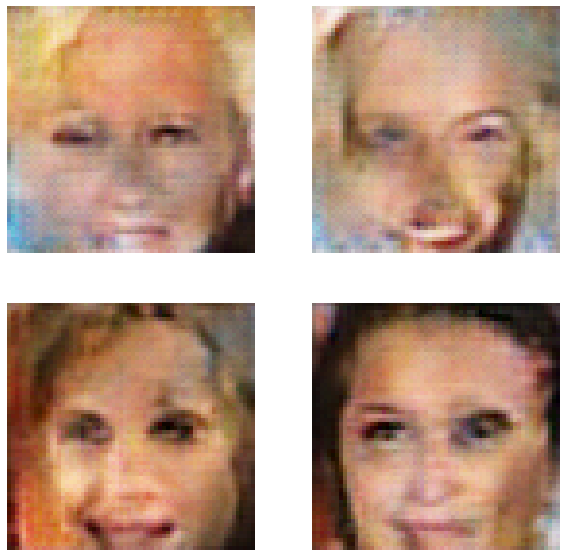

Epoch: 21,  Loss: D_real = 0.735, D_fake = 0.669,  G = 0.890
Epoch: 22,  Loss: D_real = 0.746, D_fake = 0.652,  G = 0.861
Epoch: 23,  Loss: D_real = 0.643, D_fake = 0.625,  G = 0.813
Epoch: 24,  Loss: D_real = 0.646, D_fake = 0.630,  G = 0.931
Epoch: 25,  Loss: D_real = 0.726, D_fake = 0.636,  G = 0.838
>Accuracy [real: 48%, fake: 91%]


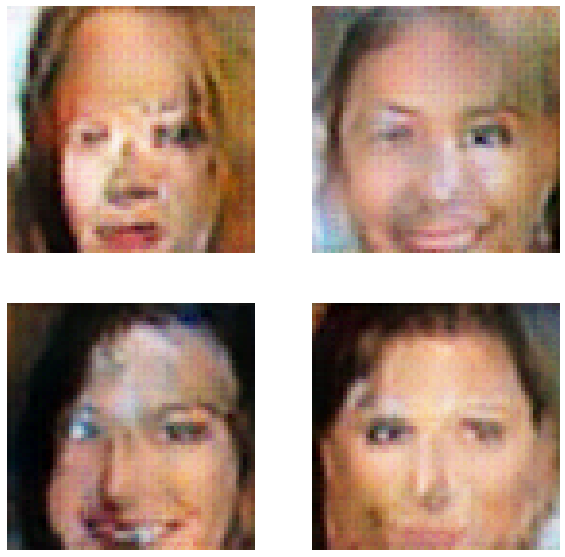

Epoch: 26,  Loss: D_real = 0.698, D_fake = 0.711,  G = 0.790
Epoch: 27,  Loss: D_real = 0.597, D_fake = 0.693,  G = 0.815
Epoch: 28,  Loss: D_real = 0.698, D_fake = 0.646,  G = 0.755
Epoch: 29,  Loss: D_real = 0.707, D_fake = 0.660,  G = 0.758
Epoch: 30,  Loss: D_real = 0.628, D_fake = 0.655,  G = 0.789
>Accuracy [real: 44%, fake: 75%]


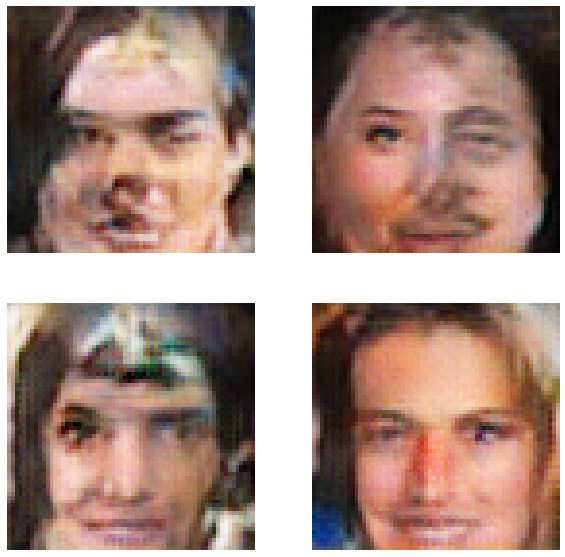

Epoch: 31,  Loss: D_real = 0.766, D_fake = 0.641,  G = 0.805
Epoch: 32,  Loss: D_real = 0.653, D_fake = 0.659,  G = 0.842
Epoch: 33,  Loss: D_real = 0.749, D_fake = 0.749,  G = 0.821
Epoch: 34,  Loss: D_real = 0.747, D_fake = 0.606,  G = 0.813
Epoch: 35,  Loss: D_real = 0.670, D_fake = 0.674,  G = 0.838
>Accuracy [real: 56%, fake: 90%]


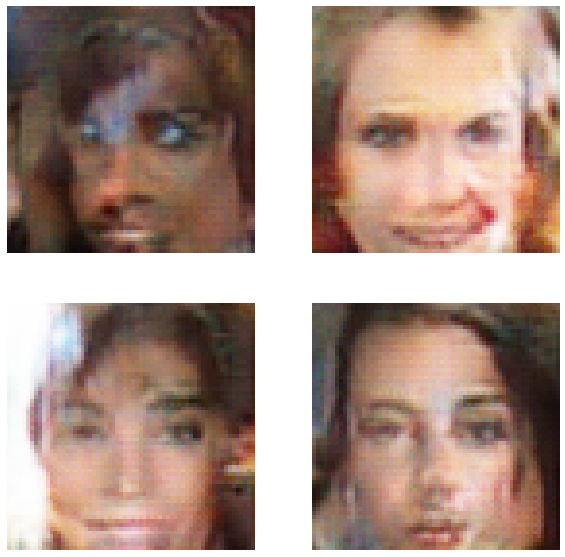

Epoch: 36,  Loss: D_real = 0.646, D_fake = 0.662,  G = 0.805
Epoch: 37,  Loss: D_real = 0.695, D_fake = 0.633,  G = 0.881
Epoch: 38,  Loss: D_real = 0.611, D_fake = 0.713,  G = 0.774
Epoch: 39,  Loss: D_real = 0.654, D_fake = 0.639,  G = 0.860
Epoch: 40,  Loss: D_real = 0.597, D_fake = 0.636,  G = 0.877
>Accuracy [real: 53%, fake: 78%]


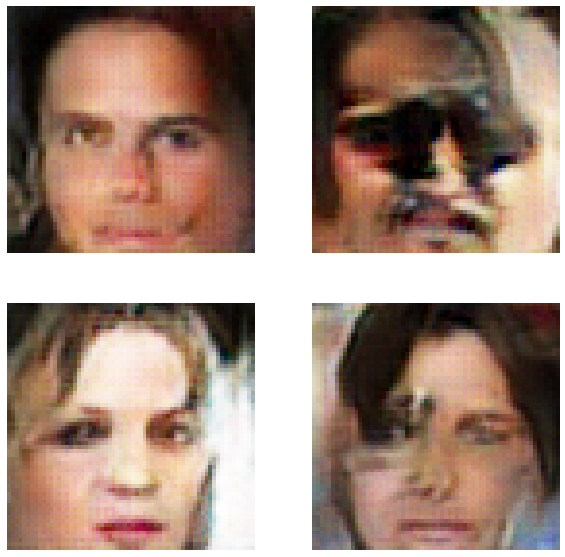

Epoch: 41,  Loss: D_real = 0.675, D_fake = 0.662,  G = 0.807
Epoch: 42,  Loss: D_real = 0.727, D_fake = 0.655,  G = 0.835
Epoch: 43,  Loss: D_real = 0.716, D_fake = 0.617,  G = 0.824
Epoch: 44,  Loss: D_real = 0.650, D_fake = 0.660,  G = 0.785
Epoch: 45,  Loss: D_real = 0.685, D_fake = 0.706,  G = 0.792
>Accuracy [real: 50%, fake: 78%]


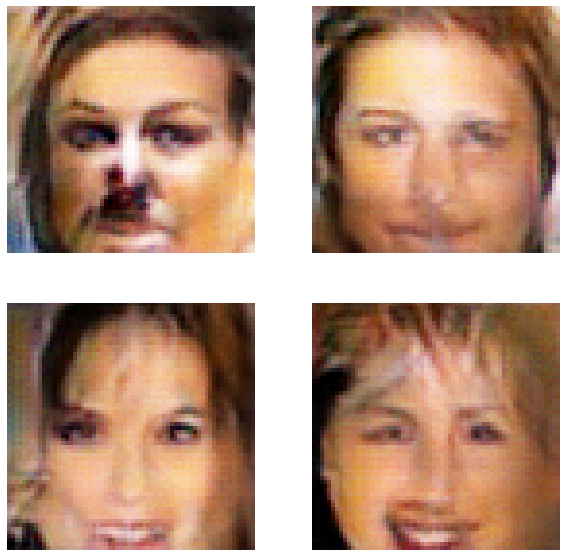

Epoch: 46,  Loss: D_real = 0.664, D_fake = 0.673,  G = 0.774
Epoch: 47,  Loss: D_real = 0.702, D_fake = 0.613,  G = 0.839
Epoch: 48,  Loss: D_real = 0.663, D_fake = 0.689,  G = 0.772
Epoch: 49,  Loss: D_real = 0.686, D_fake = 0.678,  G = 0.794
Epoch: 50,  Loss: D_real = 0.716, D_fake = 0.714,  G = 0.789
>Accuracy [real: 55%, fake: 85%]


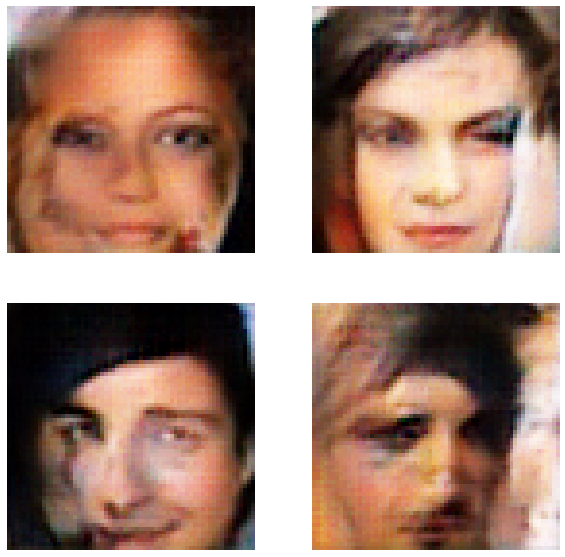

Epoch: 51,  Loss: D_real = 0.704, D_fake = 0.651,  G = 0.817
Epoch: 52,  Loss: D_real = 0.657, D_fake = 0.977,  G = 0.812
Epoch: 53,  Loss: D_real = 0.729, D_fake = 0.722,  G = 0.864
Epoch: 54,  Loss: D_real = 0.689, D_fake = 0.680,  G = 0.772
Epoch: 55,  Loss: D_real = 0.685, D_fake = 0.681,  G = 0.847
>Accuracy [real: 30%, fake: 74%]


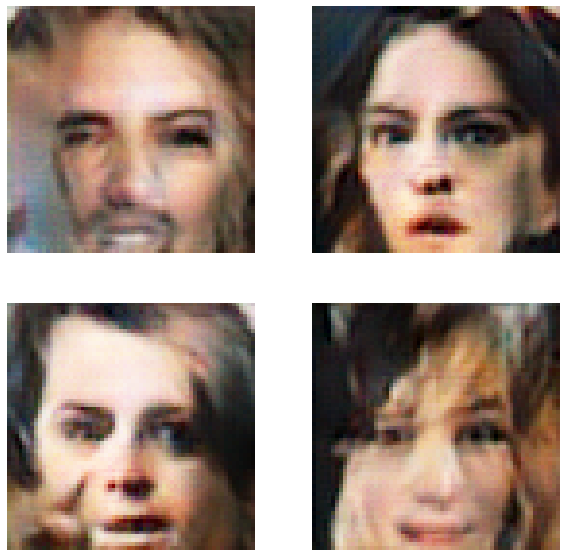

Epoch: 56,  Loss: D_real = 0.686, D_fake = 0.661,  G = 0.835
Epoch: 57,  Loss: D_real = 0.736, D_fake = 0.624,  G = 0.854
Epoch: 58,  Loss: D_real = 0.672, D_fake = 0.661,  G = 0.787
Epoch: 59,  Loss: D_real = 0.681, D_fake = 0.757,  G = 0.875
Epoch: 60,  Loss: D_real = 0.654, D_fake = 0.690,  G = 0.770
>Accuracy [real: 42%, fake: 84%]


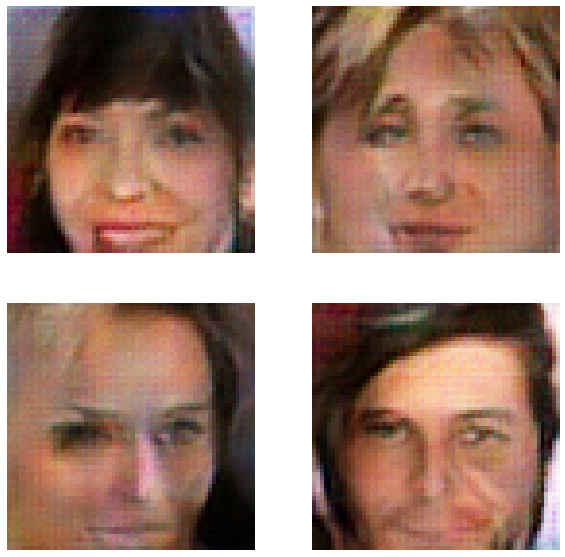

Epoch: 61,  Loss: D_real = 0.679, D_fake = 0.642,  G = 0.788
Epoch: 62,  Loss: D_real = 0.626, D_fake = 0.699,  G = 0.784
Epoch: 63,  Loss: D_real = 0.595, D_fake = 0.666,  G = 0.796
Epoch: 64,  Loss: D_real = 0.708, D_fake = 0.658,  G = 0.806
Epoch: 65,  Loss: D_real = 0.713, D_fake = 0.605,  G = 0.816
>Accuracy [real: 37%, fake: 84%]


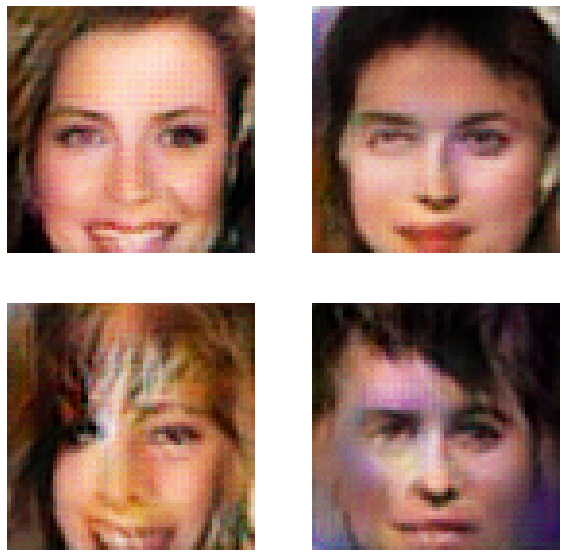

Epoch: 66,  Loss: D_real = 0.702, D_fake = 0.636,  G = 0.788
Epoch: 67,  Loss: D_real = 0.687, D_fake = 0.649,  G = 0.830
Epoch: 68,  Loss: D_real = 0.741, D_fake = 0.706,  G = 0.816
Epoch: 69,  Loss: D_real = 0.656, D_fake = 0.673,  G = 0.823
Epoch: 70,  Loss: D_real = 0.724, D_fake = 0.676,  G = 0.816
>Accuracy [real: 36%, fake: 87%]


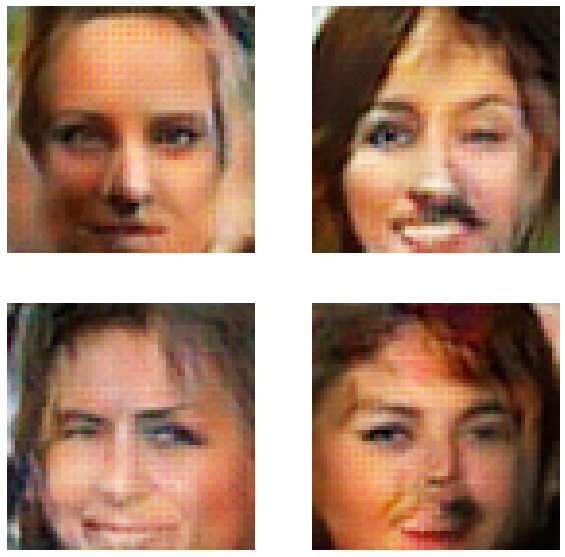

Epoch: 71,  Loss: D_real = 0.665, D_fake = 0.659,  G = 0.786
Epoch: 72,  Loss: D_real = 0.693, D_fake = 0.737,  G = 0.801
Epoch: 73,  Loss: D_real = 0.592, D_fake = 0.625,  G = 0.744
Epoch: 74,  Loss: D_real = 0.719, D_fake = 0.713,  G = 0.815
Epoch: 75,  Loss: D_real = 0.663, D_fake = 0.613,  G = 0.784
>Accuracy [real: 65%, fake: 86%]


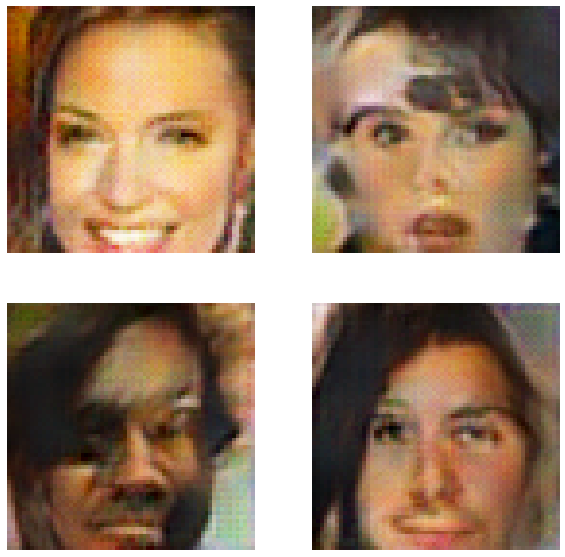

Epoch: 76,  Loss: D_real = 0.694, D_fake = 0.745,  G = 0.792
Epoch: 77,  Loss: D_real = 0.681, D_fake = 0.713,  G = 0.759
Epoch: 78,  Loss: D_real = 0.726, D_fake = 0.667,  G = 0.802
Epoch: 79,  Loss: D_real = 0.629, D_fake = 0.680,  G = 0.803
Epoch: 80,  Loss: D_real = 0.638, D_fake = 0.633,  G = 0.815
>Accuracy [real: 54%, fake: 79%]


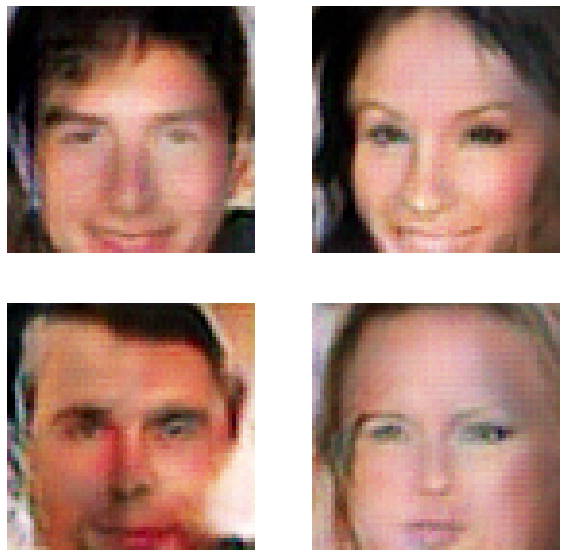

Epoch: 81,  Loss: D_real = 0.651, D_fake = 0.741,  G = 0.770
Epoch: 82,  Loss: D_real = 0.656, D_fake = 0.717,  G = 0.816
Epoch: 83,  Loss: D_real = 0.673, D_fake = 0.685,  G = 0.817
Epoch: 84,  Loss: D_real = 0.691, D_fake = 0.656,  G = 0.789
Epoch: 85,  Loss: D_real = 0.658, D_fake = 0.675,  G = 0.779
>Accuracy [real: 66%, fake: 84%]


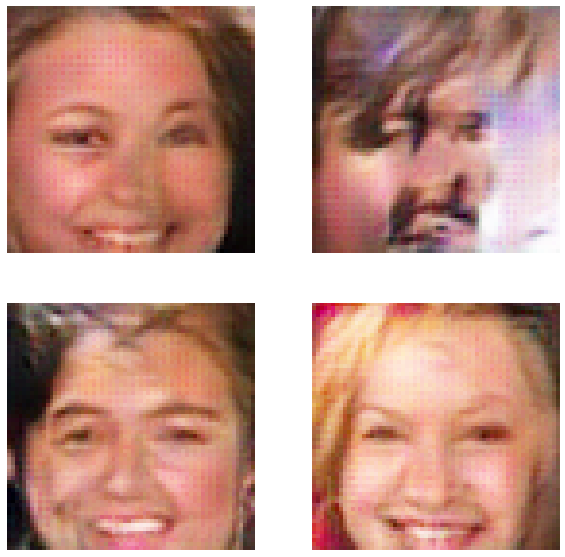

Epoch: 86,  Loss: D_real = 0.646, D_fake = 0.787,  G = 0.782
Epoch: 87,  Loss: D_real = 0.765, D_fake = 0.721,  G = 0.804
Epoch: 88,  Loss: D_real = 0.669, D_fake = 0.599,  G = 0.806
Epoch: 89,  Loss: D_real = 0.690, D_fake = 0.679,  G = 0.854
Epoch: 90,  Loss: D_real = 0.680, D_fake = 0.758,  G = 0.800
>Accuracy [real: 60%, fake: 72%]


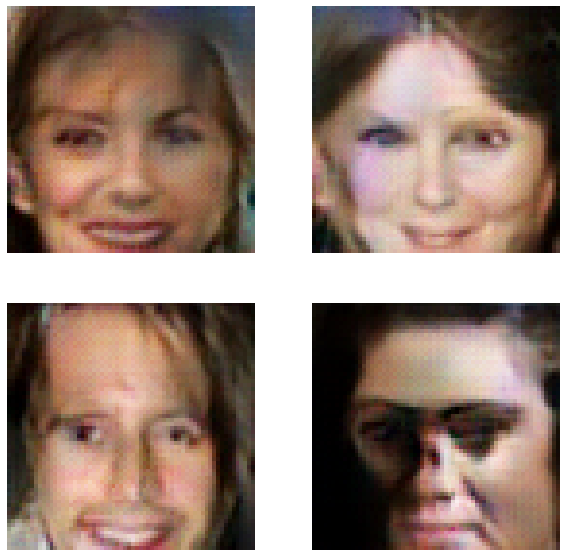

Epoch: 91,  Loss: D_real = 0.668, D_fake = 0.607,  G = 0.828
Epoch: 92,  Loss: D_real = 0.699, D_fake = 0.685,  G = 0.858
Epoch: 93,  Loss: D_real = 0.718, D_fake = 0.692,  G = 0.843
Epoch: 94,  Loss: D_real = 0.601, D_fake = 0.698,  G = 0.749
Epoch: 95,  Loss: D_real = 0.662, D_fake = 0.690,  G = 0.816
>Accuracy [real: 45%, fake: 82%]


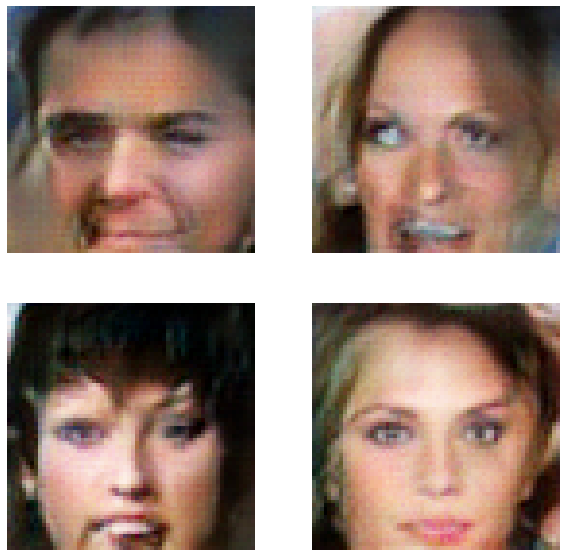

Epoch: 96,  Loss: D_real = 0.685, D_fake = 0.642,  G = 0.902
Epoch: 97,  Loss: D_real = 0.688, D_fake = 0.673,  G = 0.823
Epoch: 98,  Loss: D_real = 0.651, D_fake = 0.649,  G = 0.799
Epoch: 99,  Loss: D_real = 0.651, D_fake = 0.690,  G = 0.770
Epoch: 100,  Loss: D_real = 0.604, D_fake = 0.810,  G = 0.814
>Accuracy [real: 55%, fake: 74%]


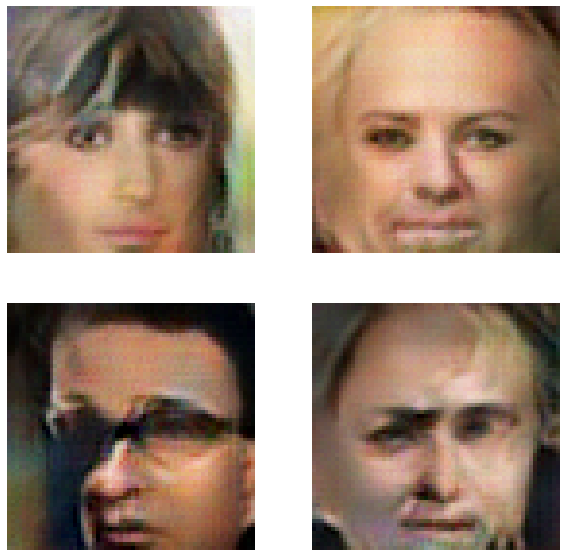

Epoch: 101,  Loss: D_real = 0.672, D_fake = 0.647,  G = 0.777
Epoch: 102,  Loss: D_real = 0.616, D_fake = 0.742,  G = 0.809
Epoch: 103,  Loss: D_real = 0.650, D_fake = 0.675,  G = 0.770
Epoch: 104,  Loss: D_real = 0.646, D_fake = 0.648,  G = 0.871
Epoch: 105,  Loss: D_real = 0.596, D_fake = 0.667,  G = 0.862
>Accuracy [real: 40%, fake: 82%]


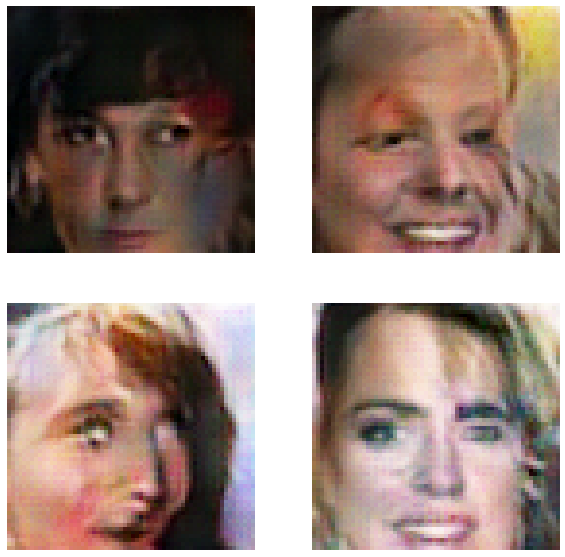

Epoch: 106,  Loss: D_real = 0.651, D_fake = 0.761,  G = 0.812
Epoch: 107,  Loss: D_real = 0.573, D_fake = 0.674,  G = 0.842
Epoch: 108,  Loss: D_real = 0.719, D_fake = 0.669,  G = 0.789
Epoch: 109,  Loss: D_real = 0.692, D_fake = 0.673,  G = 0.840
Epoch: 110,  Loss: D_real = 0.740, D_fake = 0.614,  G = 0.786
>Accuracy [real: 53%, fake: 82%]


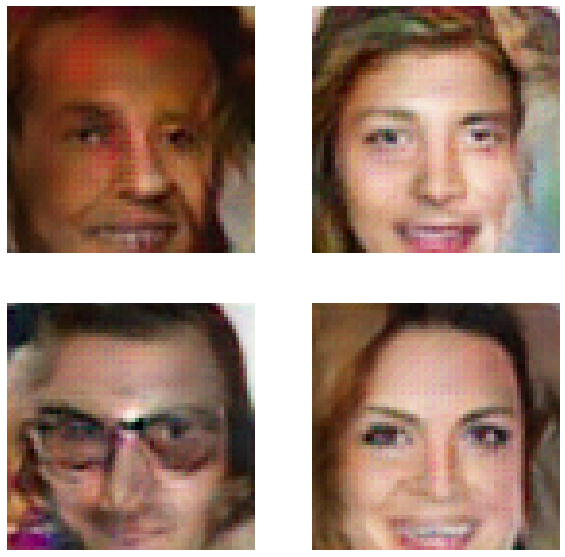

Epoch: 111,  Loss: D_real = 0.650, D_fake = 0.631,  G = 0.846
Epoch: 112,  Loss: D_real = 0.699, D_fake = 0.682,  G = 0.764
Epoch: 113,  Loss: D_real = 0.634, D_fake = 0.677,  G = 0.817
Epoch: 114,  Loss: D_real = 0.624, D_fake = 0.685,  G = 0.781
Epoch: 115,  Loss: D_real = 0.724, D_fake = 0.671,  G = 0.846
>Accuracy [real: 47%, fake: 87%]


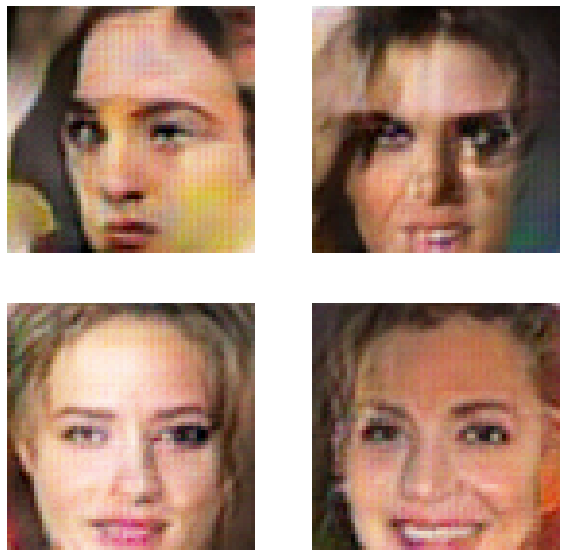

Epoch: 116,  Loss: D_real = 0.658, D_fake = 0.721,  G = 0.851
Epoch: 117,  Loss: D_real = 0.700, D_fake = 0.643,  G = 0.768
Epoch: 118,  Loss: D_real = 0.613, D_fake = 0.665,  G = 0.876
Epoch: 119,  Loss: D_real = 0.604, D_fake = 0.967,  G = 0.874
Epoch: 120,  Loss: D_real = 0.601, D_fake = 0.618,  G = 0.840
>Accuracy [real: 54%, fake: 85%]


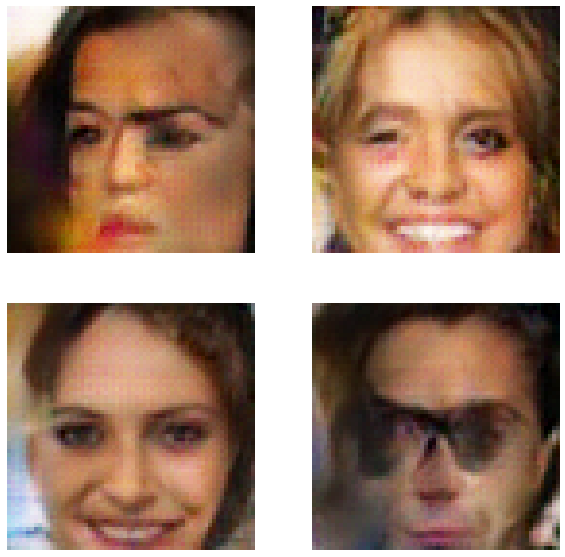

Total time for training 120 epochs is 2106.3010449409485 sec


In [90]:
# train model
train(generator, discriminator, gan, dataset, latent_dim, n_epoch, batch_size)

(-0.5, 288.5, 265.5, -0.5)

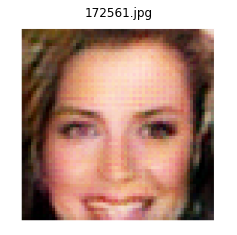

In [97]:
# 3 images generated by the gan that appear realistic
g_dir= '../input/generated'
plt.figure(figsize=(4,4))
img = plt.imread(g_dir+'/image_0065 (2).png')
plt.imshow(img)
plt.title(name)
plt.axis('off')

(-0.5, 325.5, 273.5, -0.5)

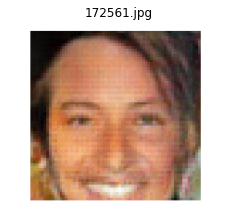

In [103]:
plt.figure(figsize=(4,4))
img = plt.imread(g_dir+'/image_0115 (2).png')
plt.imshow(img)
plt.title(name)
plt.axis('off')

(-0.5, 272.5, 273.5, -0.5)

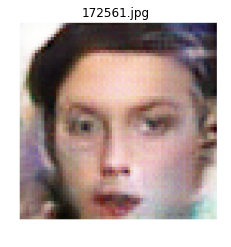

In [107]:
plt.figure(figsize=(4,4))
img = plt.imread(g_dir+'/image_0075 (2).png')
plt.imshow(img)
plt.title(name)
plt.axis('off')